## 通过神经网络预测房价
在这个项目中，我们希望能够构建神经网络来预测房屋的价格

首先，我们导入一些必要的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


读取训练集和测试集的数据

In [2]:
train = pd.read_csv('./all/train.csv')
test = pd.read_csv('./all/test.csv')

可以具体看看前面 5 个训练集长什么样子，可以看到，前面都是这个房屋的属性，最后是房屋的价格

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


接着我们可以看看训练集和测试集分别有多少个样本

In [4]:
print('一共有 {} 个训练集样本'.format(train.shape[0]))
print('一共有 {} 个测试集样本'.format(test.shape[0]))

一共有 1460 个训练集样本
一共有 1459 个测试集样本


接着我们开始对数据进行处理，首先我们取出**第二个特征**到**倒数第二个特征**，这些特征作为我们神经网络的输入特征

In [5]:
all_features = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                          test.loc[:, 'MSSubClass':'SaleCondition']))

接着我们需要进行数据标准化，对于所有的数值特征，我们都会减去均值，除以方差

In [6]:
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index # 取出所有的数值特征

# 减去均值，除以方差
all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x: (x - x.mean()) 
                                                                / (x.std()))

In [7]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal


In [8]:
# 对预测的价格取 log，价格的输出值太大，可能会影响网络的效果
train['SalePrice'] = np.log(train['SalePrice'])

如果你仔细看看上面的特征，你会发现，除了数值特征之外，还有很多非数值特征，这些特征我们没有办法将其转换成数值表示，所以我们通过 pandas 的内置函数将其转换成种类表示

比如 **MSZoning** 有两种可能，一种是 RL，一种是 RM，那么我们就将这个特征变成两个新的特征，RL 和 RM，如果这个数据在 **MSZoning** 上是 RL，那么 RL 取 1，RM 取 0；反之如果这个特征是 RM，那么 RL 取 0，RM 取 1.

| RL | RM |
|-|-|
| 0 | 1 |
| 1 | 0 |

In [9]:
pd.get_dummies(all_features, dummy_na=True).head().columns[pd.get_dummies(all_features, dummy_na=True).head().columns.str.contains('MSZoning')]

Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'MSZoning_nan'],
      dtype='object')

In [10]:
all_features = pd.get_dummies(all_features, dummy_na=True)

除此之外，我们会发现整个数据中有一些丢失数据，这些丢失数据都是 'NA'，我们没有办法将这些数据输入到网络中，所以需要对这些丢失数据进行赋值，这里我们将数据的均值填入到丢失数据中

In [11]:
all_features = all_features.fillna(all_features.mean())
feat_dim = all_features.shape[1]

前面我们已经做好了数据的预处理，下面我们将所有的训练集和验证集都取出成为一个 numpy 的数组

In [12]:
num_train = int(0.9 * train.shape[0]) # 划分训练样本和验证集样本
indices = np.arange(train.shape[0])
np.random.shuffle(indices)  # shuffle 顺序
train_indices = indices[:num_train]
valid_indices = indices[num_train:]

# 提取训练集和验证集的特征
train_features = all_features.iloc[train_indices].values.astype(np.float32)
train_features = torch.from_numpy(train_features)
valid_features = all_features.iloc[valid_indices].values.astype(np.float32)
valid_features = torch.from_numpy(valid_features)
train_valid_features = all_features[:train.shape[0]].values.astype(np.float32) # 将 train 和 valid 合并
train_valid_features = torch.from_numpy(train_valid_features)

# 提取训练集和验证集的label
train_labels = train['SalePrice'].values[train_indices, None].astype(np.float32)
train_labels = torch.from_numpy(train_labels)
valid_labels = train['SalePrice'].values[valid_indices, None].astype(np.float32)
valid_labels = torch.from_numpy(valid_labels)
train_valid_labels = train['SalePrice'].values[:, None].astype(np.float32)
train_valid_labels = torch.from_numpy(train_valid_labels)

In [13]:
test_features = all_features[train.shape[0]:].values.astype(np.float32)
test_features = torch.from_numpy(test_features)

下面是构建神经网络的地方，可以构建任意想要的神经网络

In [19]:
class Module_Net(nn.Module):
    def __init__(self, num_input, num_output, *num_hidden):
        print('num_hidden[0]', num_hidden[0])
        super(Module_Net, self).__init__()
        self.layter1 = nn.Linear(num_input, num_hidden[0])
        self.layter2 = nn.ReLU()
        self.layter3 = nn.Linear(num_hidden[0], num_output)
        
    def forward(self, x):
        x = self.layter1(x)
        x = self.layter2(x)
        x = self.layter3(x)
        return x
    
net = Module_Net(feat_dim, 1, 100)
print(net)

num_hidden[0] 10
Module_Net(
  (layter1): Linear(in_features=331, out_features=10, bias=True)
  (layter2): ReLU()
  (layter3): Linear(in_features=10, out_features=1, bias=True)
)


在评估模型的时候，为了保证大的价格和小的价格对模型都有着近似相同的影响，我们不会直接使用前面定义的均方误差作为最后的评价函数，我们会对预测的价格和真实的价格取 log，然后计算他们之间均方误差的平方根来作为评价指标，这里的指标我们已经在 `utils.py` 中实现了，感兴趣的同学可以去看看。

In [20]:
from utils import train_model, pred

num_hidden[0] 10
epoch: 10, train rmse: 0.147, valid rmse: 0.160

epoch: 20, train rmse: 0.107, valid rmse: 0.126

epoch: 30, train rmse: 0.097, valid rmse: 0.118

epoch: 40, train rmse: 0.093, valid rmse: 0.116

epoch: 50, train rmse: 0.092, valid rmse: 0.116

epoch: 60, train rmse: 0.091, valid rmse: 0.117

epoch: 70, train rmse: 0.090, valid rmse: 0.117

epoch: 80, train rmse: 0.090, valid rmse: 0.119

epoch: 90, train rmse: 0.091, valid rmse: 0.120

epoch: 100, train rmse: 0.091, valid rmse: 0.121



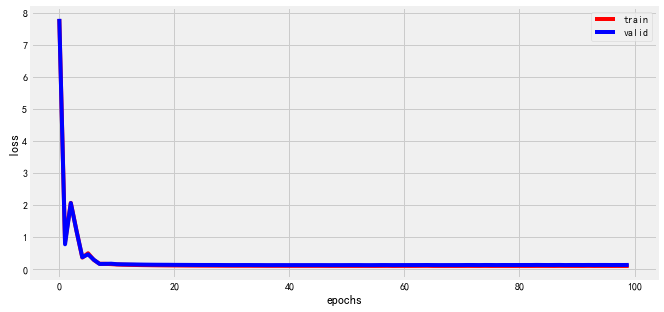

In [23]:
# 可以调整的超参
batch_size = 128
epochs = 100
lr = 0.01
wd = 0
use_gpu = False

net = Module_Net(feat_dim, 1, 10)
train_model(net, train_features, train_labels, valid_features, valid_labels, epochs, 
            batch_size, lr, wd, use_gpu)

当我们构建好了训练的过程，下面就开始了不断地调参尝试，最后得到一个效果最好的模型

num_hidden[0] 10
epoch: 10, train rmse: 0.133

epoch: 20, train rmse: 0.110

epoch: 30, train rmse: 0.106

epoch: 40, train rmse: 0.100

epoch: 50, train rmse: 0.099

epoch: 60, train rmse: 0.100

epoch: 70, train rmse: 0.098

epoch: 80, train rmse: 0.097

epoch: 90, train rmse: 0.102

epoch: 100, train rmse: 0.100



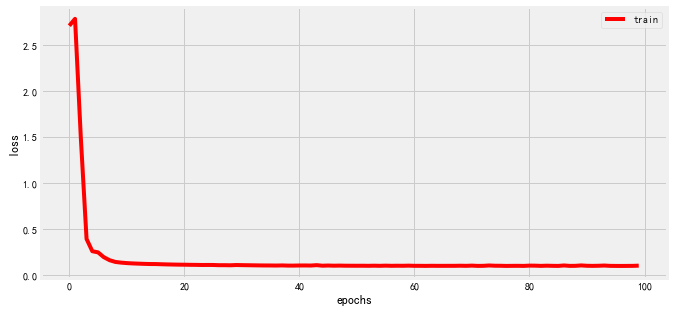

In [25]:
net = Module_Net(feat_dim, 1, 10)
train_model(net, train_valid_features, train_valid_labels, None, None, epochs, 
            batch_size, lr, wd, use_gpu)

运行下面的代码，可以通过训练好的模型预测 testset 的结果，会在当前目录生成 `submission.csv` 用于提交

In [26]:
pred(net, test, test_features)